#MINI PROJECT

PROJECT IDEA: SENTIMENTAL ANALYSIS OF TWITTER TWEETS

TEAM MEMBERS

22MCR001        ABDULLAH A S M

22MCR010        BALAJI S

22MCR044        KAVINKUMAR K

# LIBRARIES

In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.feature_extraction.text import CountVectorizer

import gensim

import re
from wordcloud import WordCloud
import nltk

from tqdm import tqdm
from gensim.models.doc2vec import LabeledSentence

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


#Dataset

In [1]:
!pip install scikit-learn-intelex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 50.1 MB/s eta 0:00:00


In [5]:
train = pd.read_csv('/content/sample_data/train_tweet.csv')
test = pd.read_csv('/content/sample_data/test_tweets.csv')

print(train.shape)
print(test.shape)

(31962, 3)
(17197, 2)


# Preprocessing and Cleaning of Data

In [8]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [9]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [10]:
train.isnull().any()
test.isnull().any()

id       False
tweet    False
dtype: bool

In [11]:
train.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [12]:
# checking out the negative comments from the train set

train[train['label'] == 0].head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


In [13]:
# checking out the postive comments from the train set 

train[train['label'] == 1].head(10)

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'buil...
14,15,1,no comment! in #australia #opkillingbay #se...
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'...
56,57,1,@user lets fight against #love #peace
68,69,1,ð©the white establishment can't have blk fol...
77,78,1,"@user hey, white people: you can call people '..."
82,83,1,how the #altright uses &amp; insecurity to lu...
111,112,1,@user i'm not interested in a #linguistics tha...


Text(0.5, 1.0, 'COUNT OF POSITIVE AND NEGATIVE TWEETS')

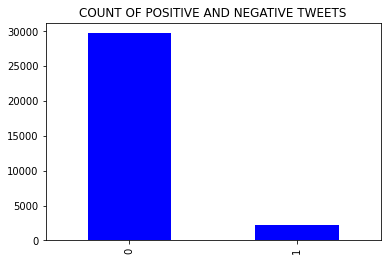

In [14]:
train['label'].value_counts().plot.bar(color = 'blue', figsize = (6, 4))
plt.title("COUNT OF POSITIVE AND NEGATIVE TWEETS")

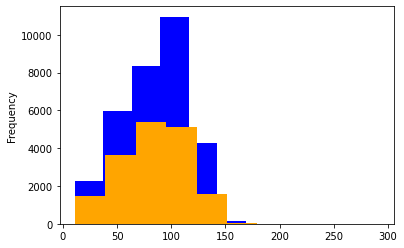

In [15]:
# checking the distribution of tweets in the data

length_train = train['tweet'].str.len().plot.hist(color = 'blue', figsize = (6, 4))
length_test = test['tweet'].str.len().plot.hist(color = 'orange', figsize = (6, 4))

In [16]:
# adding a column to represent the length of the tweet

train['len'] = train['tweet'].str.len()
test['len'] = test['tweet'].str.len()

train.head(10)

,id,label,tweet,len
0,1,0,@user when a father is dysfunctional and is s...,102
1,2,0,@user @user thanks for #lyft credit i can't us...,122
2,3,0,bihday your majesty,21
3,4,0,#model i love u take with u all the time in ...,86
4,5,0,factsguide: society now #motivation,39
5,6,0,[2/2] huge fan fare and big talking before the...,116
6,7,0,@user camping tomorrow @user @user @user @use...,74
7,8,0,the next school year is the year for exams.ð...,143
8,9,0,we won!!! love the land!!! #allin #cavs #champ...,87
9,10,0,@user @user welcome here ! i'm it's so #gr...,50


In [17]:

train.groupby('label').describe()

id                                                               \
         count          mean          std   min      25%      50%       75%   
label                                                                         
0      29720.0  15974.454441  9223.783469   1.0  7981.75  15971.5  23965.25   
1       2242.0  16074.896075  9267.955758  14.0  8075.25  16095.0  24022.00   

                    len                                                        
           max    count       mean        std   min   25%   50%    75%    max  
label                                                                          
0      31962.0  29720.0  84.328634  29.566484  11.0  62.0  88.0  107.0  274.0  
1      31961.0   2242.0  90.187779  27.375502  12.0  69.0  96.0  111.0  152.0

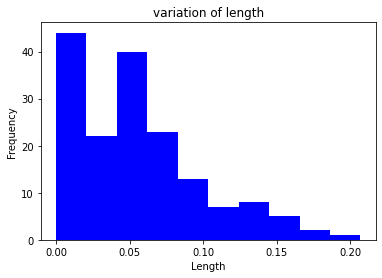

In [18]:
train.groupby('len').mean()['label'].plot.hist(color = 'blue', figsize = (6, 4),)
plt.title('variation of length')
plt.xlabel('Length')
plt.show()

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

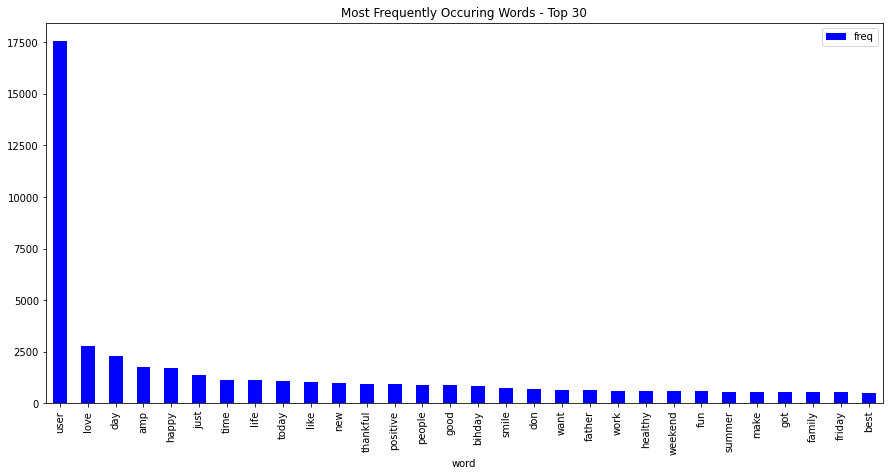

In [19]:
#CountVectorizer is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text. 
#This is helpful when we have multiple such texts, and we wish to convert each word in each text into vectors 
#(for using in further text analysis)

cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(train.tweet)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

#Displaying the top 30 frequently used word from the train dataset


Text(0.5, 1.0, 'WordCloud - Vocabulary from Reviews')

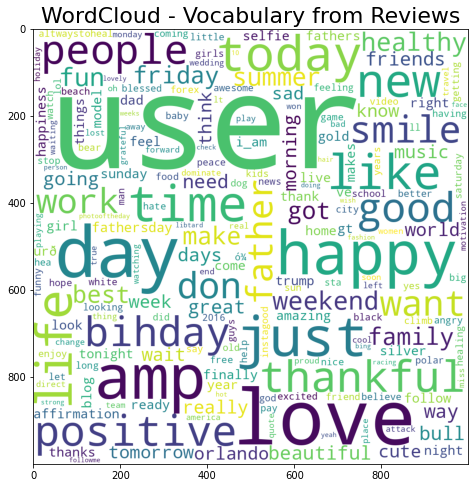

In [20]:
#wordcloud is Significant textual data points can be highlighted using a word cloud. 
from wordcloud import WordCloud

wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary from Reviews", fontsize = 22)

#Displays the most frequently words according to the weight 

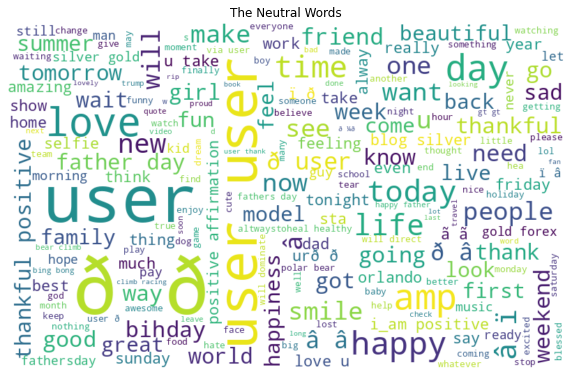

In [21]:
normal_words =' '.join([text for text in train['tweet'][train['label'] == 0]])

wordcloud = WordCloud(background_color = 'white',width=800, height=500, random_state = 0, max_font_size = 110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Neutral Words')
plt.show()


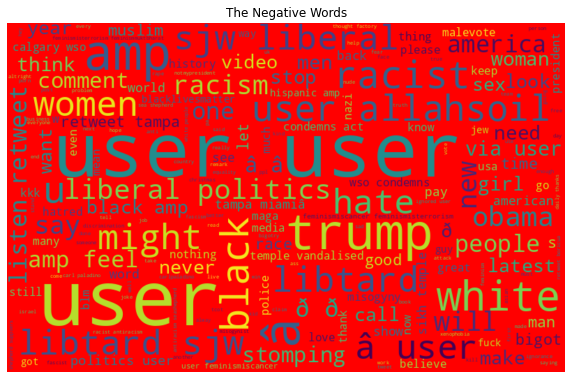

In [22]:
negative_words =' '.join([text for text in train['tweet'][train['label'] == 1]])

wordcloud = WordCloud(background_color = 'red', width=800, height=500, random_state = 0, max_font_size = 110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Negative Words')
plt.show()


In [23]:
# collecting the hashtags
import re
def hashtag_extract(x):
    hashtags = []
    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [24]:
# extracting hashtags from non racist/sexist tweets
HT_regular = hashtag_extract(train['tweet'][train['label'] == 0])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_regular

['run',
 'lyft',
 'disapointed',
 'getthanked',
 'model',
 'motivation',
 'allshowandnogo',
 'school',
 'exams',
 'hate',
 'imagine',
 'actorslife',
 'revolutionschool',
 'girl',
 'allin',
 'cavs',
 'champions',
 'cleveland',
 'clevelandcavaliers',
 'gr8',
 'ireland',
 'blog',
 'silver',
 'gold',
 'forex',
 'orlando',
 'standwithorlando',
 'pulseshooting',
 'orlandoshooting',
 'biggerproblems',
 'selfish',
 'heabreaking',
 'values',
 'love',
 '80days',
 'gettingfed',
 'got7',
 'junior',
 'yugyoem',
 'omg',
 'thankful',
 'positive',
 'friday',
 'cookies',
 'euro2016',
 'badday',
 'coneofshame',
 'cats',
 'pissed',
 'funny',
 'laughs',
 'wine',
 'weekend',
 'tgif',
 'ff',
 'gamedev',
 'indiedev',
 'indiegamedev',
 'squad',
 'upsideofflorida',
 'shopalyssas',
 'love',
 'smiles',
 'media',
 'pressconference',
 'antalya',
 'turkey',
 'throwback',
 'ica16',
 'rip',
 'orlando',
 'alohafriday',
 'time',
 'not',
 'exist',
 'positivevibes',
 'hawaiian',
 'goodnight',
 'badmonday',
 'taylorswift1

In [25]:
# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(train['tweet'][train['label'] == 1])
HT_negative = sum(HT_negative,[])
HT_negative

['cnn',
 'michigan',
 'tcot',
 'australia',
 'opkillingbay',
 'seashepherd',
 'helpcovedolphins',
 'thecove',
 'helpcovedolphins',
 'neverump',
 'xenophobia',
 'love',
 'peace',
 'race',
 'identity',
 'medâ',
 'altright',
 'whitesupremacy',
 'linguistics',
 'race',
 'power',
 'raciolinguistics',
 'brexit',
 'people',
 'trump',
 'republican',
 'michelleobama',
 'knicks',
 'golfâ',
 'jewishsupremacist',
 'libtard',
 'sjw',
 'liberal',
 'politics',
 'trash',
 'hate',
 'â',
 'stereotyping',
 'prejudice',
 'hope',
 'hate',
 'conflictâ',
 'pols',
 'bluelivesmatter',
 'draintheswamp',
 'ferguson',
 '2016',
 'antisemitism',
 'hocoschools',
 'columbiamd',
 'hocomd',
 'nazi',
 'hatred',
 'bigotry',
 'libtard',
 'sjw',
 'liberal',
 'politics',
 'p2',
 'p21',
 'fyi',
 'tcot',
 'topoli',
 'blacklivesmatter',
 'ushistory',
 'eugenics',
 'biherism',
 'bigotry',
 'altright',
 'potus',
 'theresistance',
 'crime',
 'officerâ',
 'black',
 'retweet',
 'tampa',
 'miamiâ',
 'allahsoil',
 'praised',
 'clevel

In [26]:
import nltk
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
list(a.keys())

['run',
 'lyft',
 'disapointed',
 'getthanked',
 'model',
 'motivation',
 'allshowandnogo',
 'school',
 'exams',
 'hate',
 'imagine',
 'actorslife',
 'revolutionschool',
 'girl',
 'allin',
 'cavs',
 'champions',
 'cleveland',
 'clevelandcavaliers',
 'gr8',
 'ireland',
 'blog',
 'silver',
 'gold',
 'forex',
 'orlando',
 'standwithorlando',
 'pulseshooting',
 'orlandoshooting',
 'biggerproblems',
 'selfish',
 'heabreaking',
 'values',
 'love',
 '80days',
 'gettingfed',
 'got7',
 'junior',
 'yugyoem',
 'omg',
 'thankful',
 'positive',
 'friday',
 'cookies',
 'euro2016',
 'badday',
 'coneofshame',
 'cats',
 'pissed',
 'funny',
 'laughs',
 'wine',
 'weekend',
 'tgif',
 'ff',
 'gamedev',
 'indiedev',
 'indiegamedev',
 'squad',
 'upsideofflorida',
 'shopalyssas',
 'smiles',
 'media',
 'pressconference',
 'antalya',
 'turkey',
 'throwback',
 'ica16',
 'rip',
 'alohafriday',
 'time',
 'not',
 'exist',
 'positivevibes',
 'hawaiian',
 'goodnight',
 'badmonday',
 'taylorswift1989',
 'travelingram'

In [27]:
list(a.values())

[33,
 2,
 1,
 2,
 364,
 166,
 1,
 24,
 6,
 24,
 3,
 8,
 1,
 166,
 2,
 11,
 4,
 9,
 1,
 1,
 18,
 345,
 299,
 298,
 265,
 235,
 2,
 11,
 59,
 1,
 3,
 14,
 4,
 1531,
 1,
 1,
 2,
 1,
 1,
 26,
 491,
 874,
 225,
 5,
 129,
 5,
 1,
 26,
 11,
 140,
 3,
 28,
 265,
 77,
 39,
 30,
 25,
 17,
 27,
 7,
 10,
 59,
 18,
 1,
 1,
 13,
 20,
 2,
 91,
 4,
 43,
 11,
 3,
 30,
 4,
 28,
 1,
 4,
 3,
 1,
 2,
 3,
 2,
 1,
 1,
 2,
 3,
 1,
 69,
 7,
 9,
 1,
 16,
 3,
 1,
 352,
 363,
 2,
 2,
 9,
 15,
 2,
 2,
 89,
 278,
 2,
 10,
 1,
 2,
 114,
 32,
 71,
 254,
 1,
 61,
 3,
 7,
 6,
 144,
 3,
 51,
 2,
 255,
 17,
 17,
 49,
 153,
 75,
 1,
 3,
 25,
 3,
 1,
 7,
 4,
 1,
 125,
 5,
 2,
 2,
 11,
 8,
 12,
 3,
 1,
 9,
 84,
 53,
 13,
 21,
 2,
 1,
 25,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 29,
 295,
 570,
 168,
 5,
 11,
 4,
 15,
 24,
 34,
 6,
 1,
 50,
 27,
 12,
 18,
 30,
 3,
 1,
 67,
 108,
 122,
 434,
 1,
 1,
 33,
 1,
 1,
 1,
 1,
 2,
 2,
 73,
 3,
 27,
 16,
 156,
 1,
 6,
 13,
 3,
 6,
 46,
 5,
 58,
 1,
 1,
 5,
 152,
 29,
 213,
 548,
 1,
 29,
 1

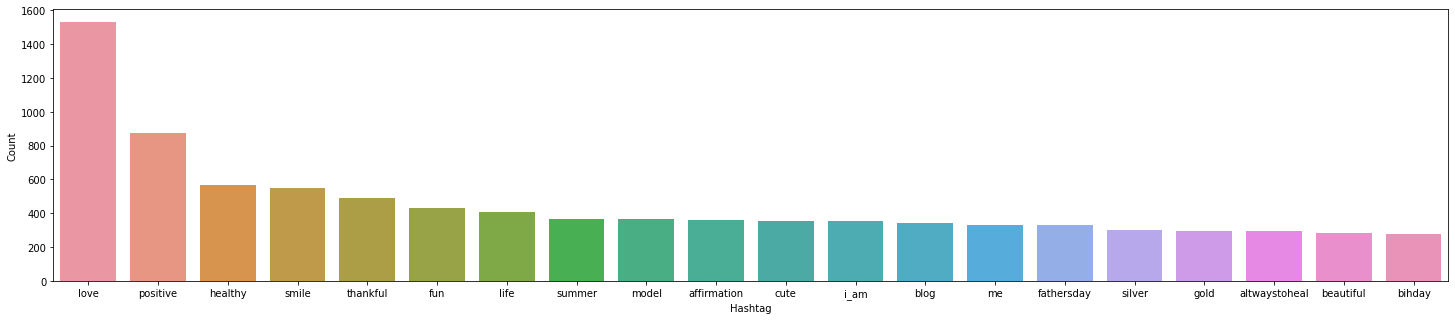

In [28]:
# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(25,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [41]:
# removing unwanted patterns from the data

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [42]:
train_corpus = []

for i in range(0, 31962):
  review = re.sub('[^a-zA-Z]', ' ', train['tweet'][i])
  review = review.lower()
  review = review.split()
  
  ps = PorterStemmer()
  
  # stemming
  review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
  
  # joining them back with space
  review = ' '.join(review)
  train_corpus.append(review)

In [43]:
train_corpus

['user father dysfunct selfish drag kid dysfunct run',
 'user user thank lyft credit use caus offer wheelchair van pdx disapoint getthank',
 'bihday majesti',
 'model love u take u time ur',
 'factsguid societi motiv',
 'huge fan fare big talk leav chao pay disput get allshowandnogo',
 'user camp tomorrow user user user user user user user danni',
 'next school year year exam think school exam hate imagin actorslif revolutionschool girl',
 'love land allin cav champion cleveland clevelandcavali',
 'user user welcom gr',
 'ireland consum price index mom climb previou may blog silver gold forex',
 'selfish orlando standwithorlando pulseshoot orlandoshoot biggerproblem selfish heabreak valu love',
 'get see daddi today day gettingf',
 'user cnn call michigan middl school build wall chant tcot',
 'comment australia opkillingbay seashepherd helpcovedolphin thecov helpcovedolphin',
 'ouch junior angri got junior yugyoem omg',
 'thank paner thank posit',
 'retweet agre',
 'friday smile around

In [44]:
test_corpus = []

for i in range(0, 17197):
  review = re.sub('[^a-zA-Z]', ' ', test['tweet'][i])
  review = review.lower()
  review = review.split()
  
  ps = PorterStemmer()
  
  # stemming
  review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
  
  # joining them back with space
  review = ' '.join(review)
  test_corpus.append(review)

In [45]:
# creating bag of words

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features = 2500)
x = cv.fit_transform(train_corpus).toarray()
y = train.iloc[:, 1]

print(x.shape)
print(y.shape)


(31962, 2500)
(31962,)


In [46]:
# creating bag of words

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features = 2500)
x_test = cv.fit_transform(test_corpus).toarray()

print(x_test.shape)


(17197, 2500)


In [47]:
# splitting the training data into train and valid sets

from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.25, random_state = 42)

print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(23971, 2500)
(7991, 2500)
(23971,)
(7991,)


# Feature Scaling

In [48]:
# standardization

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_valid = sc.transform(x_valid)
x_test = sc.transform(x_test)


# RandomForestClassifier Model

In [49]:
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

model = RandomForestClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("F1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)



Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Training Accuracy : 0.9980392974844604
Validation Accuracy : 0.9565761481666876
F1 score : 0.6165745856353592
[[7365   67]
 [ 280  279]]


# Logistic Regression Model

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearnex import patch_sklearn
patch_sklearn()

model = LogisticRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
/usr/local/lib/python3.9/dist-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy : 0.9851070042968587
Validation Accuracy : 0.9416843949443123
f1 score : 0.5933682373472949
[[7185  247]
 [ 219  340]]


# DecisionTreeClassifier Model

In [51]:
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Training Accuracy : 0.9991656585040257
Validation Accuracy : 0.9330496808910024
f1 score : 0.5415595544130248
[[7140  292]
 [ 243  316]]


# SVC Model

In [52]:
from sklearnex.svm import SVC
from sklearnex import patch_sklearn
patch_sklearn()

model = SVC()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Training Accuracy : 0.978181969880272
Validation Accuracy : 0.9521962207483419
f1 score : 0.4986876640419947
[[7419   13]
 [ 369  190]]


# XGBClassifier Model

In [53]:
from sklearnex import patch_sklearn
patch_sklearn()
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Training Accuracy : 0.9603687789412206
Validation Accuracy : 0.9555750218996371
f1 score : 0.5748502994011976
[[7396   36]
 [ 319  240]]


# Conclusion


Among many models used to predict, the RandomForestClassifier is the model with highest accuracy and f1 score. Hence its the best suited model.
